In [1]:
#imports
import numpy as np
import pandas as pd
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)
import os
from dotenv import load_dotenv
load_dotenv()
import requests
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from pathlib import Path
%matplotlib inline

In [4]:
#Import ETF CSV
csvpath = Path("Resources/Data_ETFs.csv")
ETF_df = pd.read_csv(csvpath)
ETF_df.isnull().sum().sum()


12938

In [5]:
ETF_df = ETF_df.fillna(method ='pad')
ETF_df.head()

,Unnamed: 0,QQQ_close,QQQ_return,QQQ_SMA50,QQQ_SMA200,QQQ_Vol,SPBO_close,SPBO_return,SPBO_SMA50,SPBO_SMA200,...,VMBS_close,VMBS_return,VMBS_SMA50,VMBS_SMA200,VMBS_Vol,TLT_close,TLT_return,TLT_SMA50,TLT_SMA200,TLT_Vol
0,2011-05-02,58.9924,NaN,NaN,NaN,44312089,NaN,NaN,NaN,NaN,...,50.7700,NaN,NaN,NaN,9903.0,93.6300,NaN,NaN,NaN,4389946
1,2011-05-03,58.6900,-0.005126,NaN,NaN,30746589,NaN,NaN,NaN,NaN,...,50.8590,0.001753,NaN,NaN,3887.0,94.1500,0.005554,NaN,NaN,5952435
2,2011-05-04,58.6000,-0.001533,NaN,NaN,48174869,NaN,NaN,NaN,NaN,...,50.8176,-0.000814,NaN,NaN,3146.0,94.5900,0.004673,NaN,NaN,6600138
3,2011-05-05,58.2800,-0.005461,NaN,NaN,60501065,NaN,NaN,NaN,NaN,...,50.9880,0.003353,NaN,NaN,1731.0,95.4600,0.009198,NaN,NaN,7990952
4,2011-05-06,58.4800,0.003432,NaN,NaN,59986642,NaN,NaN,NaN,NaN,...,51.0400,0.001020,NaN,NaN,11474.0,95.0701,-0.004084,NaN,NaN,8701719


In [6]:
VMBS = pd.DataFrame(ETF_df['VMBS_close'])
VMBS.head()

,VMBS_close
0,50.7700
1,50.8590
2,50.8176
3,50.9880
4,51.0400


In [7]:
#Create X and y and define the window
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)


In [8]:
# Define the window size
window_size = 1

# Set the index of the feature and target columns
feature_column = 0
target_column = 0
# Create the features (X) and target (y) data using the window_data() function.
X, y = window_data(VMBS, window_size, feature_column, target_column)

# Print a few sample values from X and y
print (f"X sample values:\n{X[:3]} \n")
print (f"y sample values:\n{y[:3]}")

X sample values:
[[50.77  ]
 [50.859 ]
 [50.8176]] 

y sample values:
[[50.859 ]
 [50.8176]
 [50.988 ]]


In [9]:
# Manually splitting the data
split = int(0.7 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [10]:
# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the MinMaxScaler object with the features data X
scaler.fit(X)

# Scale the features training and testing sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Fit the MinMaxScaler object with the target data Y
scaler.fit(y)

# Scale the target training and testing sets
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [11]:
# Reshape the features data
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Print some sample data after reshaping the datasets
print (f"X_train sample values:\n{X_train[:3]} \n")
print (f"X_test sample values:\n{X_test[:3]}")

X_train sample values:
[[[0.12888889]]

 [[0.14866667]]

 [[0.13946667]]] 

X_test sample values:
[[[0.25777778]]

 [[0.26222222]]

 [[0.23555556]]]


In [12]:
model = Sequential()

# Initial model setup
number_units = 50
dropout_fraction = .75

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [13]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [14]:
# Show the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 50)             10400     
_________________________________________________________________
dropout (Dropout)            (None, 1, 50)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 50)             20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 5

In [15]:
# Train the model
model.fit(X_train, y_train, epochs=250, shuffle=False, batch_size=90, verbose=1)

Epoch 1/250
20/20 [==============================] - 5s 5ms/step - loss: 0.1948
Epoch 2/250
20/20 [==============================] - 0s 6ms/step - loss: 0.1150
Epoch 3/250
20/20 [==============================] - 0s 5ms/step - loss: 0.0345
Epoch 4/250
20/20 [==============================] - 0s 5ms/step - loss: 0.0478
Epoch 5/250
20/20 [==============================] - 0s 5ms/step - loss: 0.0357
Epoch 6/250
20/20 [==============================] - 0s 5ms/step - loss: 0.0363
Epoch 7/250
20/20 [==============================] - 0s 5ms/step - loss: 0.0318
Epoch 8/250
20/20 [==============================] - 0s 5ms/step - loss: 0.0339
Epoch 9/250
20/20 [==============================] - 0s 5ms/step - loss: 0.0315
Epoch 10/250
20/20 [==============================] - 0s 5ms/step - loss: 0.0288
Epoch 11/250
20/20 [==============================] - 0s 5ms/step - loss: 0.0305
Epoch 12/250
20/20 [==============================] - 0s 5ms/step - loss: 0.0264
Epoch 13/250
20/20 [=================

In [17]:
# Evaluate the model
model.evaluate(X_test, y_test, verbose=0)

0.0020646892953664064

In [18]:
# Make predictions using the testing data X_test
predicted = model.predict(X_test)

In [19]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [20]:
# Create a DataFrame of Real and Predicted values
ETF_prediction = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = ETF_df.index[-len(real_prices): ]) 

# Show the DataFrame's head
ETF_prediction.head()

,Actual,Predicted
1712,51.370,51.468765
1713,51.250,51.485840
1714,51.255,51.383766
1715,51.360,51.388000
1716,51.420,51.477299


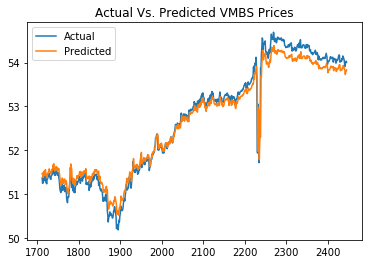

In [22]:
# Plot the real vs predicted prices as a line chart
ETF_prediction.plot(title="Actual Vs. Predicted VMBS Prices")

In [1]:
#Forecasting Predictions
